In [55]:
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

# Путь к папке с данными
dataset_dir = "./train"
# Я захардкодил, поэтому архив с данными нужно будет распаковать самому, если будете запускать код

In [49]:
# Создаем датасеты
batch_size = 32
raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    dataset_dir,
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=1337
)
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    'train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=1337
)

raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    "test", batch_size=batch_size
)

Found 8000 files belonging to 4 classes.
Using 6400 files for training.
Found 8000 files belonging to 4 classes.
Using 1600 files for validation.
Found 8000 files belonging to 4 classes.


In [50]:
# Предобработка данных
max_features = 5000
sequence_length = 300

vectorize_layer = layers.TextVectorization(
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length
)

train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

# Применяем векторизацию к данным
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

# Кэширование и предварительная загрузка данных для улучшения производительности
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [51]:
num_classes = 4
model = tf.keras.Sequential([
    layers.Embedding(max_features + 1, 128, input_length=sequence_length),
    layers.GlobalMaxPooling1D(),
    layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    layers.Dropout(0.6),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

# Добавим обратные вызовы для отслеживания точности на каждой эпохе
callbacks = [tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)]

# Обучение модели
history = model.fit(train_ds, validation_data=val_ds, epochs=5, callbacks=callbacks)

# Оценка модели на тестовом датасете
loss, accuracy = model.evaluate(test_ds)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_16 (Embedding)    (None, 300, 128)          640128    
                                                                 
 global_max_pooling1d_16 (G  (None, 128)               0         
 lobalMaxPooling1D)                                              
                                                                 
 dense_36 (Dense)            (None, 128)               16512     
                                                                 
 dropout_21 (Dropout)        (None, 128)               0         
                                                                 
 dense_37 (Dense)            (None, 4)                 516       
                                                                 
Total params: 657156 (2.51 MB)
Trainable params: 657156 (2.51 MB)
Non-trainable params: 0 (0.00 Byte)
_________________

Text(0.5, 1.0, 'Training and Validation Loss')

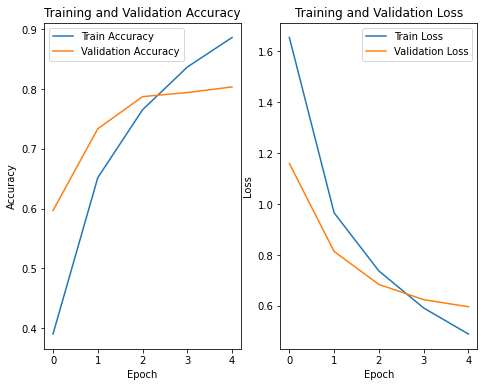

In [52]:
# График точности на обучающих и валидационных данных
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

# График значения функции потерь на обучающих и валидационных данных
plt.subplot(1, 3, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

## Видно, что после второй эпохи на валидационных данных точность практически не растет, а функция потерь остается почти на том же уровне. Это значит, что 2-3 эпох было бы достаточно для обучения. Если обучать модель дальше, то она будет переобучена

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 24ms/step


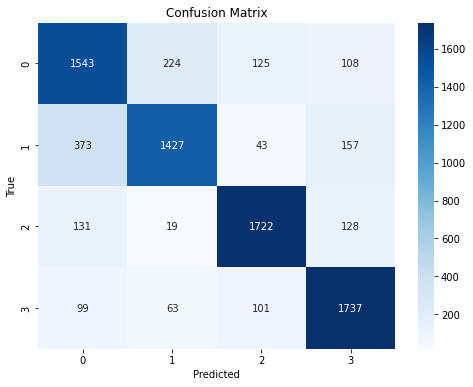

In [53]:
# Построение матрицы ошибок
y_true = []
y_pred = []

for x, y in test_ds:
    y_true.extend(y.numpy())
    y_pred.extend(np.argmax(model.predict(x), axis=1))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

plt.show()
